### Data transformation

In [1]:
# dataset 호출 이전에 resizing을 위한 transformation 객체 생성
from torchvision import transforms

# transformation 정의하기
data_transform = transforms.Compose([
    transforms.Resize((32, 32)), transforms.ToTensor(),
])

### Data download


In [2]:
# MNIST dataset 호출
from torchvision import datasets, transforms
path = "/home/helpme/dataset/"

# trainset 불러오기
train_data = datasets.MNIST(path, train=True, download=True, transform=data_transform)

# testset 불러오기
test_data = datasets.MNIST(path, train=False, download=True, transform=data_transform)

### Data 전처리


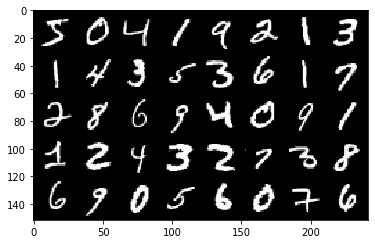

In [3]:
# sample image 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# training data 분리 
x_train, y_train = train_data.data, train_data.targets

# test data 분리
x_test, y_test = test_data.data, test_data.targets

# (image, Height, width) => (image, channel, height, width)로 변환
if len(x_train.shape) == 3 :
    x_train = x_train.unsqueeze(1)

if len(x_test.shape) == 3 :
    x_test = x_test.unsqueeze(1)

# tensor => image로 변환하여 보여주는 함수 정의

def show(img):
    # tensor image를 numpy 형태로 변환
    np_img = img.numpy()
    # (channel, height, width) 를 (height, width, channel로) 변경
    np_img_trans = np_img.transpose((1,2,0))
    plt.imshow(np_img_trans, interpolation="nearest")

# image grid를 생성하고 출력
# 총 40개 이미지, 한 행당 8개 이미지 출력
x_grid = utils.make_grid(x_train[:40], nrow=8)

show(x_grid)

In [4]:
# 다운받은 dataset을 DataLoader로 불러내기
from torch.utils.data import DataLoader

train_set = DataLoader(train_data, batch_size = 32, shuffle=True)
test_set = DataLoader(test_data, batch_size = 32)

### LeNet 구현


In [5]:
from torch import nn
import torch.nn.functional as F

class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, 2)
        x = torch.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, 2)
        x = torch.tanh(self.conv3(x))
        x = x.view(-1, 120) 
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

model = LeNet_5()
print(model)

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
import torch
device = torch.device('cuda')
model.to(device)

print(next(model.parameters()).device)

cuda:0


In [7]:
from torchsummary import summary
summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Conv2d-3            [-1, 120, 1, 1]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


### loss function 정의

In [8]:
loss_func = nn.CrossEntropyLoss(reduction='sum')

In [9]:
# optimizer 정의
from torch import optim
opt = optim.Adam(model.parameters(), lr=0.001)

# # 현재 lr 계산하는 함수 정의
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# learning rate schedular 정의
from torch.optim.lr_scheduler import CosineAnnealingLR
lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-05)

### 학습용 함수 정의

In [10]:
# 배치당 performance metric 을 계산하는 함수 정의
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


In [11]:
# 배치당 loss를 계산하는 함수를 정의
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b


In [12]:
# epoch당 loss와 performance metric을 계산하는 함수 정의
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.type(torch.float).to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True: # sanity_check가 True이면 1epoch만 학습합니다.
            break

    loss = running_loss / float(len_data)
    metric = running_metric / float(len_data)
    return loss, metric


In [13]:
# train_val 함수 정의
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {
        'train': [],
        'val': [],
    }

    metric_history = {
        'train': [],
        'val': [],
    }

    # best model parameter를 저장합니다.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
            loss_history['val'].append(val_loss)
            metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights')

        lr_scheduler.step()

        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f' %(train_loss, val_loss, 100*val_metric))
        print('-'*10)

    # best model을 반환합니다.
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history


### 모델 학습

In [14]:
import copy
import os

# 학습된 모델의 가중치를 저장할 폴더를 만듭니다.
os.makedirs('/home/helpme/models/', exist_ok=True)

# 하이퍼 파라미터를 설정합니다.
params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_set,
 "val_dl": test_set,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "/home/helpme/models/LeNet-5.pt",
}


In [15]:
# 모델을 학습합니다.
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/2, current lr=0.001
Copied best model weights
train loss: 1.558419, dev loss: 1.505643, accuracy: 95.82
----------
Epoch 1/2, current lr=0.000505
Copied best model weights
train loss: 1.494347, dev loss: 1.490814, accuracy: 97.32
----------
Epoch 2/2, current lr=1e-05
Copied best model weights
train loss: 1.485106, dev loss: 1.486743, accuracy: 97.64
----------


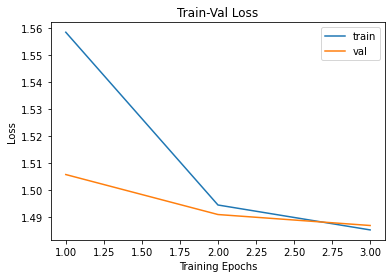

In [16]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


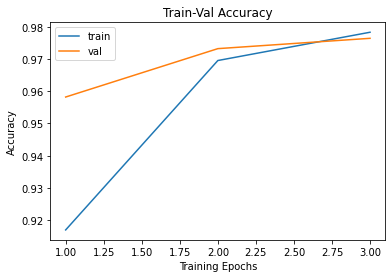

In [17]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()
